In [1]:
Alpha_Name = "AlphaNet_Original_Input_5d_return"
start_time = "2020-01-01"
forecast_months = 6 # months
feat_num = 9
sequence = 3

In [2]:
import os
from os import walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
from progressbar import ProgressBar
from tqdm import tqdm
import time
import multiprocessing as mp
import sys
sys.path.append("/home/wuwenjun/jupyter_code/Shannon/AlphaNet")
path = '/home/wuwenjun/Data/' + Alpha_Name +'/'
output_path = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/result/"
model_dir = "/home/wuwenjun/Alpha_Factor/" + "LSTM_" + Alpha_Name + "/model/"
input_length = feat_num * (feat_num - 1) + 4 * feat_num
if os.path.exists(output_path) == False:
    os.makedirs(output_path)
    print(output_path)

In [3]:
time_list = []
data_path = path + "Final/"
dataframe_list = pd.DataFrame()
for f, _, i in walk(data_path):
    for j in tqdm(i):
        time_list.append(j)
time_list.sort()     
for count,item in enumerate(time_list):
    if item.startswith(start_time):
        train_timestamp = time_list[:count]
        test_timestamp = time_list[count:count + forecast_months//3]
        break
display(train_timestamp)
display(test_timestamp)

model_path = (model_dir + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1]).replace(".par","/")
if os.path.exists(model_path) == False:
    os.makedirs(model_path)
    print(model_path)

100%|██████████| 26/26 [00:00<00:00, 403895.94it/s]


['2015-01-01_2015-03-01.par',
 '2015-03-01_2015-06-01.par',
 '2015-06-01_2015-09-01.par',
 '2015-09-01_2016-01-01.par',
 '2016-01-01_2016-03-01.par',
 '2016-03-01_2016-06-01.par',
 '2016-06-01_2016-09-01.par',
 '2016-09-01_2017-01-01.par',
 '2017-01-01_2017-03-01.par',
 '2017-03-01_2017-06-01.par',
 '2017-06-01_2017-09-01.par',
 '2017-09-01_2018-01-01.par',
 '2018-01-01_2018-03-01.par',
 '2018-03-01_2018-06-01.par',
 '2018-06-01_2018-09-01.par',
 '2018-09-01_2019-01-01.par',
 '2019-01-01_2019-03-01.par',
 '2019-03-01_2019-06-01.par',
 '2019-06-01_2019-09-01.par',
 '2019-09-01_2020-01-01.par']

['2020-01-01_2020-03-01.par', '2020-03-01_2020-06-01.par']

In [4]:
trainx , trainy , testx , testy = [] , [] , [],  []

for train in tqdm(train_timestamp):
    df = pd.read_parquet(path+ "Final/" + train).set_index(["timestamp","ticker"])
    trainx.append(df.drop("target",axis=1))
    trainy.append(df['target'])
trainx = pd.concat(trainx,axis=0)
trainy = pd.concat(trainy,axis=0)

display(trainx)
display(trainy)


for test in tqdm(test_timestamp):
    df = pd.read_parquet(path+ "Final/" + test).set_index(["timestamp","ticker"])
    testx.append(df.drop("target",axis=1))
    testy.append(df['target'])
testx = pd.concat(testx,axis=0)
testy = pd.concat(testy,axis=0)
target_list = pd.DataFrame(testy.copy())
display(testx)
display(testy)

100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2015-02-16 09:30:00,1,1047.509016,165.116922,249.851660,924.464829,243.390500,183.194222,926.891342,158.088300,78.887819,957.587687,...,861850.412364,0.138453,-0.376716,0.284385,1.522075,1.245018,0.876160,3.017927,2.468587,1.737222
2015-02-17 09:30:00,1,1284.106922,304.746632,233.319300,1251.132811,325.347890,190.544389,1311.161194,268.878420,78.529422,1262.525551,...,825372.445636,-1.631951,-0.601635,0.240629,1.601496,1.147820,0.839082,3.175407,2.275878,1.663689
2015-02-25 09:30:00,1,1515.538580,320.840611,242.242430,1522.025569,325.437271,214.401980,1539.154187,259.118036,99.405562,1482.690747,...,784033.056545,-1.377793,-0.151133,0.292173,1.574869,1.078356,0.797058,3.122595,2.138158,1.580369
2015-02-26 09:30:00,1,1466.712161,355.378729,244.332118,1546.573639,318.650776,222.730596,1381.349806,297.507667,108.085628,1469.916341,...,727636.666545,-0.375218,-0.482991,0.038896,1.643798,1.006125,0.739729,3.259280,1.994944,1.466684
2015-02-27 09:30:00,1,1271.480107,335.406489,121.012389,1338.104279,252.973056,186.957378,1296.812044,215.993378,108.132489,1324.356569,...,756908.456182,-0.411738,-0.287113,0.381687,1.581575,1.159289,0.769491,3.135918,2.298631,1.525691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25 09:30:00,688389,0.717597,0.132396,0.128393,0.573326,0.154487,0.067029,0.595819,0.098409,0.058362,0.648569,...,32752.930545,-1.494300,1.104107,-0.019865,12.889787,11.698700,9.424807,12.889787,11.698700,9.424807
2019-12-26 09:30:00,688389,0.687183,0.164358,0.126508,0.560489,0.174990,0.069812,0.537811,0.106142,0.065703,0.621105,...,32703.618545,-1.062827,0.276873,0.323804,11.736496,12.433038,9.410618,11.736496,12.433038,9.410618
2019-12-27 09:30:00,688389,0.404211,0.170479,0.135013,0.300933,0.185134,0.078756,0.254311,0.104358,0.078968,0.361575,...,33045.135455,-0.579624,0.041667,0.748616,10.971425,12.116078,9.508887,10.971425,12.116078,9.508887


timestamp            ticker
2015-02-16 09:30:00  1        -0.679514
2015-02-17 09:30:00  1        -0.824485
2015-02-25 09:30:00  1        -0.790990
2015-02-26 09:30:00  1        -1.006040
2015-02-27 09:30:00  1        -1.213373
                                 ...   
2019-12-25 09:30:00  688389   -0.559038
2019-12-26 09:30:00  688389   -0.477997
2019-12-27 09:30:00  688389   -0.430200
2019-12-30 09:30:00  688389   -0.053279
2019-12-31 09:30:00  688389    0.128167
Name: target, Length: 3796142, dtype: float64

100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


,,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
timestamp,ticker,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00,1,930.974427,1189.989146,119.823498,586.173551,907.109662,21.270372,496.040438,1211.632566,-6.310924,631.520977,...,700216.562182,-0.252885,1.034487,-0.018404,0.309860,0.422665,0.360829,0.699122,0.953624,0.814091
2020-01-03 09:30:00,1,508.189413,1817.282544,180.232144,349.191600,1607.496633,78.309228,322.570358,1710.834244,72.834889,381.417755,...,854750.234364,-0.309947,0.868576,0.450520,0.289802,0.428480,0.440453,0.653875,0.966715,0.993758
2020-01-06 09:30:00,1,492.936747,2311.944122,514.146293,303.935648,2161.603100,392.997612,253.344154,2131.751233,428.736718,338.487834,...,920674.613091,-0.105327,0.834089,0.738505,0.284040,0.420340,0.474427,0.640862,0.948355,1.070400
2020-01-07 09:30:00,1,331.524773,2620.202889,851.192272,198.404656,2542.934233,698.930000,192.341922,2435.144200,710.393833,206.378208,...,932384.970909,0.143989,0.748438,0.552495,0.294860,0.408182,0.480455,0.665276,0.920927,1.084018
2020-01-08 09:30:00,1,289.239351,2774.701947,1175.553790,162.295658,2539.000353,1066.541230,120.383682,2241.527818,1086.483654,147.365655,...,915870.519273,-0.079424,0.250896,0.584156,0.296269,0.403353,0.471953,0.668451,0.910013,1.064818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-25 09:30:00,688399,145.058544,102.900373,291.804320,96.556694,98.291493,310.663984,135.863911,83.149802,208.860347,115.710131,...,29397.982364,5.979449,1.024996,-0.270202,16.970444,19.273864,22.039995,16.970444,19.273864,22.039995
2020-05-26 09:30:00,688399,188.140111,73.147256,141.024870,137.441784,69.128806,153.068290,163.341413,51.128161,98.400247,157.379208,...,27335.442182,4.343320,3.362193,-0.479024,17.499125,19.485409,20.493689,17.499125,19.485409,20.493689
2020-05-27 09:30:00,688399,250.251258,116.622329,92.636120,199.366691,104.925807,100.881953,236.665444,97.351904,42.759193,223.721218,...,25205.631636,6.939820,3.436735,-0.352345,19.836240,20.228593,18.896940,19.836240,20.228593,18.896940


timestamp            ticker
2020-01-02 09:30:00  1        -0.486757
2020-01-03 09:30:00  1        -0.910133
2020-01-06 09:30:00  1        -0.852201
2020-01-07 09:30:00  1        -0.461992
2020-01-08 09:30:00  1        -0.377981
                                 ...   
2020-05-25 09:30:00  688399    0.702991
2020-05-26 09:30:00  688399    0.940820
2020-05-27 09:30:00  688399    0.229983
2020-05-28 09:30:00  688399   -0.946442
2020-05-29 09:30:00  688399   -0.852920
Name: target, Length: 365230, dtype: float64

In [5]:
# Reshape
trainx = torch.from_numpy(np.array(trainx).reshape(-1,input_length,sequence))
trainy = torch.from_numpy(np.array(trainy).reshape(-1,1))
testx = torch.from_numpy(np.array(testx).reshape(-1,input_length,sequence))
testy = torch.from_numpy(np.array(testy).reshape(-1,1))
print("trainx.shape: " , trainx.shape)
print("trainy.shape: " , trainy.shape)
print("testx.shape: " , testx.shape)
print("testy.shape: " , testy.shape)

trainx.shape:  torch.Size([3796142, 108, 3])
trainy.shape:  torch.Size([3796142, 1])
testx.shape:  torch.Size([365230, 108, 3])
testy.shape:  torch.Size([365230, 1])


In [6]:
train_dataset = Data.TensorDataset(trainx, trainy)
test_dataset = Data.TensorDataset(testx, testy)
batch_size = 1024
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16,
    pin_memory=True
)

test_loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16,
    pin_memory=True
)

In [7]:
from AlphaNet.Models import AlphaNet_LSTM_V1
from AlphaNet import Model_Loader
LR = 0.01
epoch_num = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loss_function = nn.MSELoss()


model = AlphaNet_LSTM_V1(input_length, 30)
optimizer = optim.Adam(model.parameters(), lr=LR)
model_loader = Model_Loader(model = model,optimizer=optimizer,device=device)
print(model_loader.model)

AlphaNet_LSTM_V1(
  (batch): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 30, num_layers=2, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


In [14]:
model = model_loader.fit(train_loader,loss_function = loss_function,epoch_num = epoch_num,save_path = model_path)

  0%|          | 0/10 [00:00<?, ?it/s]

Learning Rate is : 0.01


RuntimeError: running_mean should contain 3 elements not 108

In [9]:
batch = torch.nn.BatchNorm1d(108)

In [34]:
model_loader.transform

AttributeError: 'Model_Loader' object has no attribute 'transform'

In [115]:
alphanet = torch.load(model_path + "best_model.tar")
alphanet = alphanet.cuda()
# alphanet = torch.nn.parallel.DataParallel(alphanet)
print(alphanet)
total_length = trainx.shape[0]
loss_function = nn.MSELoss().cuda()
optimizer = optim.Adam(alphanet.parameters(), lr=0.001)
loss_list = list(np.load(model_path + "loss.npy"))
min_loss = min(loss_list)
for epoch in tqdm(range(150)):
    total_loss = 0
    for _, (inputs, outputs) in enumerate(train_loader):
        inputs = Variable(inputs).float().cuda()
        outputs = Variable(outputs).float().cuda()
        optimizer.zero_grad() # noticed:  the grad return to zero before starting the loop
        
        # forward + backward +update
        pred = alphanet(inputs)
        pred = pred.cuda()
        loss = loss_function(pred, outputs)
        loss.backward()
        optimizer.step()
        
#         lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        total_loss += loss.item()
    total_loss = total_loss * batch_size / total_length
    print('Epoch: ', epoch + 1, ' loss: ', total_loss)
    loss_list.append(total_loss)
    if total_loss < min_loss:
        torch.save(alphanet,model_path + "best_model.tar")
    np.save(model_path + "loss.npy", loss_list)
torch.save(alphanet,model_path + "model.tar")

  0%|          | 0/150 [00:00<?, ?it/s]

AlphaNet_LSTM(
  (batch): BatchNorm1d(108, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(108, 30, num_layers=2, batch_first=True, bidirectional=True)
  (batch2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (out): Linear(in_features=30, out_features=1, bias=True)
)


  1%|          | 1/150 [01:33<3:51:10, 93.09s/it]

Epoch:  1  loss:  0.7693714817689813


  1%|▏         | 2/150 [02:35<3:05:46, 75.31s/it]

Epoch:  2  loss:  0.7689920518917751


  2%|▏         | 3/150 [03:35<2:46:47, 68.08s/it]

Epoch:  3  loss:  0.7686765208201222


  3%|▎         | 4/150 [05:06<3:07:20, 76.99s/it]

Epoch:  4  loss:  0.7682122196529019


  3%|▎         | 5/150 [06:28<3:10:55, 79.00s/it]

Epoch:  5  loss:  0.7682027716126453


  4%|▍         | 6/150 [07:34<2:59:05, 74.62s/it]

Epoch:  6  loss:  0.7679291982621157


  5%|▍         | 7/150 [09:02<3:07:43, 78.76s/it]

Epoch:  7  loss:  0.7674093656546711


  5%|▌         | 8/150 [09:50<2:43:44, 69.18s/it]

Epoch:  8  loss:  0.7669588831932318


  6%|▌         | 9/150 [10:41<2:29:18, 63.54s/it]

Epoch:  9  loss:  0.767039001406408


  7%|▋         | 10/150 [11:52<2:33:41, 65.87s/it]

Epoch:  10  loss:  0.7665076259033937


  7%|▋         | 11/150 [13:34<2:58:05, 76.88s/it]

Epoch:  11  loss:  0.7662751058476349


  8%|▊         | 12/150 [14:35<2:45:11, 71.82s/it]

Epoch:  12  loss:  0.765950715593446


  9%|▊         | 13/150 [15:43<2:41:50, 70.88s/it]

Epoch:  13  loss:  0.7660135299074367


  9%|▉         | 14/150 [16:44<2:33:37, 67.77s/it]

Epoch:  14  loss:  0.765634913979134


 10%|█         | 15/150 [18:02<2:39:21, 70.83s/it]

Epoch:  15  loss:  0.7650512805801493


 11%|█         | 16/150 [18:52<2:24:36, 64.75s/it]

Epoch:  16  loss:  0.7648813987638755


 11%|█▏        | 17/150 [19:43<2:14:02, 60.47s/it]

Epoch:  17  loss:  0.7651566094893282


 12%|█▏        | 18/150 [20:33<2:06:24, 57.46s/it]

Epoch:  18  loss:  0.7646702806542279


 13%|█▎        | 19/150 [21:25<2:01:43, 55.75s/it]

Epoch:  19  loss:  0.764335916637708


 13%|█▎        | 20/150 [22:16<1:57:40, 54.31s/it]

Epoch:  20  loss:  0.7641548379502091


 14%|█▍        | 21/150 [24:01<2:29:28, 69.52s/it]

Epoch:  21  loss:  0.764174783373143


 15%|█▍        | 22/150 [25:12<2:29:18, 69.99s/it]

Epoch:  22  loss:  0.7635889058123578


 15%|█▌        | 23/150 [26:08<2:18:52, 65.61s/it]

Epoch:  23  loss:  0.7631419418367235


 16%|█▌        | 24/150 [27:02<2:10:40, 62.23s/it]

Epoch:  24  loss:  0.7632808258300622


 17%|█▋        | 25/150 [28:38<2:30:56, 72.45s/it]

Epoch:  25  loss:  0.763143993271371


 17%|█▋        | 26/150 [29:30<2:16:49, 66.21s/it]

Epoch:  26  loss:  0.7629284978235354


 18%|█▊        | 27/150 [30:20<2:05:34, 61.25s/it]

Epoch:  27  loss:  0.762811184430296


 19%|█▊        | 28/150 [31:19<2:03:45, 60.86s/it]

Epoch:  28  loss:  0.7624754560765079


 19%|█▉        | 29/150 [32:32<2:09:45, 64.34s/it]

Epoch:  29  loss:  0.7625043566264983


 20%|██        | 30/150 [33:28<2:03:58, 61.99s/it]

Epoch:  30  loss:  0.762196695055664


 21%|██        | 31/150 [34:19<1:56:16, 58.62s/it]

Epoch:  31  loss:  0.762109679255405


 21%|██▏       | 32/150 [35:28<2:01:24, 61.73s/it]

Epoch:  32  loss:  0.7617037724040701


 22%|██▏       | 33/150 [36:33<2:02:27, 62.80s/it]

Epoch:  33  loss:  0.7616906884520246


 23%|██▎       | 34/150 [37:31<1:58:21, 61.22s/it]

Epoch:  34  loss:  0.761470279241877


 23%|██▎       | 35/150 [38:24<1:52:19, 58.60s/it]

Epoch:  35  loss:  0.7612598372374433


 24%|██▍       | 36/150 [39:13<1:46:22, 55.98s/it]

Epoch:  36  loss:  0.7609057700962629


 25%|██▍       | 37/150 [40:05<1:43:03, 54.72s/it]

Epoch:  37  loss:  0.7610502880482828


 25%|██▌       | 38/150 [40:57<1:40:40, 53.94s/it]

Epoch:  38  loss:  0.7604855550815484


 26%|██▌       | 39/150 [41:49<1:38:25, 53.21s/it]

Epoch:  39  loss:  0.7606633759297289


 27%|██▋       | 40/150 [42:39<1:35:48, 52.26s/it]

Epoch:  40  loss:  0.7602699442643275


 27%|██▋       | 41/150 [44:22<2:02:42, 67.55s/it]

Epoch:  41  loss:  0.7604068476950864


 28%|██▊       | 42/150 [45:41<2:07:32, 70.86s/it]

Epoch:  42  loss:  0.7601534488171426


 29%|██▊       | 43/150 [46:44<2:02:10, 68.51s/it]

Epoch:  43  loss:  0.760115096332897


 29%|██▉       | 44/150 [48:07<2:08:45, 72.88s/it]

Epoch:  44  loss:  0.759981607281498


 30%|███       | 45/150 [49:00<1:57:13, 66.99s/it]

Epoch:  45  loss:  0.7597776396496572


 31%|███       | 46/150 [49:51<1:47:47, 62.19s/it]

Epoch:  46  loss:  0.75956188101521


 31%|███▏      | 47/150 [50:57<1:48:46, 63.37s/it]

Epoch:  47  loss:  0.7594372243912227


 32%|███▏      | 48/150 [52:01<1:47:48, 63.41s/it]

Epoch:  48  loss:  0.759350083299618


 33%|███▎      | 49/150 [52:56<1:42:50, 61.10s/it]

Epoch:  49  loss:  0.7591801545555009


 33%|███▎      | 50/150 [53:48<1:36:58, 58.18s/it]

Epoch:  50  loss:  0.7591142954181102


 34%|███▍      | 51/150 [55:17<1:51:17, 67.45s/it]

Epoch:  51  loss:  0.7589593340062705


 35%|███▍      | 52/150 [56:36<1:55:45, 70.87s/it]

Epoch:  52  loss:  0.7589148937964361


 35%|███▌      | 53/150 [57:38<1:50:14, 68.19s/it]

Epoch:  53  loss:  0.7585623243233011


 36%|███▌      | 54/150 [59:12<2:01:50, 76.15s/it]

Epoch:  54  loss:  0.7585116064587305


 37%|███▋      | 55/150 [1:00:13<1:53:11, 71.49s/it]

Epoch:  55  loss:  0.7588555899094778


 37%|███▋      | 56/150 [1:01:25<1:52:29, 71.80s/it]

Epoch:  56  loss:  0.7578186046619048


 38%|███▊      | 57/150 [1:02:36<1:50:40, 71.40s/it]

Epoch:  57  loss:  0.758106697953905


 39%|███▊      | 58/150 [1:04:08<1:59:04, 77.66s/it]

Epoch:  58  loss:  0.758107378127187


 39%|███▉      | 59/150 [1:04:57<1:44:40, 69.02s/it]

Epoch:  59  loss:  0.7577923415031245


 40%|████      | 60/150 [1:05:50<1:36:12, 64.14s/it]

Epoch:  60  loss:  0.7575263360941517


 41%|████      | 61/150 [1:06:45<1:31:12, 61.49s/it]

Epoch:  61  loss:  0.757416250974884


 41%|████▏     | 62/150 [1:07:40<1:27:10, 59.43s/it]

Epoch:  62  loss:  0.7575770068116802


 42%|████▏     | 63/150 [1:08:30<1:22:05, 56.62s/it]

Epoch:  63  loss:  0.7572130734766626


 43%|████▎     | 64/150 [1:09:20<1:18:27, 54.73s/it]

Epoch:  64  loss:  0.7575379209791488


 43%|████▎     | 65/150 [1:10:30<1:24:00, 59.30s/it]

Epoch:  65  loss:  0.7570694777060826


 44%|████▍     | 66/150 [1:11:43<1:28:58, 63.56s/it]

Epoch:  66  loss:  0.7569080736087429


 45%|████▍     | 67/150 [1:12:49<1:28:34, 64.03s/it]

Epoch:  67  loss:  0.7567256752618098


 45%|████▌     | 68/150 [1:13:42<1:23:00, 60.74s/it]

Epoch:  68  loss:  0.7571705758951546


 46%|████▌     | 69/150 [1:15:33<1:42:40, 76.05s/it]

Epoch:  69  loss:  0.7566898124095709


 47%|████▋     | 70/150 [1:17:29<1:57:04, 87.80s/it]

Epoch:  70  loss:  0.7563405809315278


 47%|████▋     | 71/150 [1:18:47<1:51:42, 84.85s/it]

Epoch:  71  loss:  0.7564150755012514


 48%|████▊     | 72/150 [1:20:10<1:49:45, 84.43s/it]

Epoch:  72  loss:  0.7565513609595569


 49%|████▊     | 73/150 [1:21:07<1:37:50, 76.24s/it]

Epoch:  73  loss:  0.7561182134461413


 49%|████▉     | 74/150 [1:22:12<1:32:09, 72.76s/it]

Epoch:  74  loss:  0.7560201176075155


 50%|█████     | 75/150 [1:23:19<1:28:45, 71.01s/it]

Epoch:  75  loss:  0.7561143018082911


 51%|█████     | 76/150 [1:24:15<1:22:16, 66.71s/it]

Epoch:  76  loss:  0.7555646134929197


 51%|█████▏    | 77/150 [1:25:08<1:16:00, 62.47s/it]

Epoch:  77  loss:  0.7557921562767932


 52%|█████▏    | 78/150 [1:26:00<1:11:04, 59.23s/it]

Epoch:  78  loss:  0.755481983089621


 53%|█████▎    | 79/150 [1:27:26<1:19:36, 67.28s/it]

Epoch:  79  loss:  0.7555372772280107


 53%|█████▎    | 80/150 [1:28:26<1:16:03, 65.20s/it]

Epoch:  80  loss:  0.7553718959782248


 54%|█████▍    | 81/150 [1:30:06<1:26:58, 75.63s/it]

Epoch:  81  loss:  0.755034228155149


 55%|█████▍    | 82/150 [1:30:56<1:17:04, 68.00s/it]

Epoch:  82  loss:  0.7551962435200436


 55%|█████▌    | 83/150 [1:31:49<1:10:47, 63.40s/it]

Epoch:  83  loss:  0.7550572583729941


 56%|█████▌    | 84/150 [1:32:41<1:06:03, 60.05s/it]

Epoch:  84  loss:  0.7547997600168866


 57%|█████▋    | 85/150 [1:33:57<1:10:16, 64.87s/it]

Epoch:  85  loss:  0.7550877018362013


 57%|█████▋    | 86/150 [1:35:14<1:12:53, 68.34s/it]

Epoch:  86  loss:  0.7548797003955212


 58%|█████▊    | 87/150 [1:36:24<1:12:24, 68.96s/it]

Epoch:  87  loss:  0.7548212353365085


 59%|█████▊    | 88/150 [1:38:16<1:24:26, 81.71s/it]

Epoch:  88  loss:  0.7545626937433062


 59%|█████▉    | 89/150 [1:39:18<1:17:10, 75.92s/it]

Epoch:  89  loss:  0.7544193955154961


 60%|██████    | 90/150 [1:40:14<1:09:56, 69.94s/it]

Epoch:  90  loss:  0.7545618036357803


 61%|██████    | 91/150 [1:41:06<1:03:20, 64.42s/it]

Epoch:  91  loss:  0.7543561740336432


 61%|██████▏   | 92/150 [1:42:44<1:12:14, 74.73s/it]

Epoch:  92  loss:  0.7543716096257245


 62%|██████▏   | 93/150 [1:44:03<1:12:02, 75.83s/it]

Epoch:  93  loss:  0.7539868328433089


 63%|██████▎   | 94/150 [1:45:02<1:06:03, 70.77s/it]

Epoch:  94  loss:  0.7536767121413095


 63%|██████▎   | 95/150 [1:45:53<59:34, 64.99s/it]  

Epoch:  95  loss:  0.7538758857706427


 64%|██████▍   | 96/150 [1:47:05<1:00:18, 67.01s/it]

Epoch:  96  loss:  0.7534990101245628


 65%|██████▍   | 97/150 [1:48:13<59:27, 67.31s/it]  

Epoch:  97  loss:  0.7537631068874405


 65%|██████▌   | 98/150 [1:49:12<56:12, 64.85s/it]

Epoch:  98  loss:  0.75332658063378


 66%|██████▌   | 99/150 [1:50:05<52:11, 61.40s/it]

Epoch:  99  loss:  0.7532496263591064


 67%|██████▋   | 100/150 [1:51:00<49:29, 59.39s/it]

Epoch:  100  loss:  0.7532501075645223


 67%|██████▋   | 101/150 [1:51:52<46:38, 57.11s/it]

Epoch:  101  loss:  0.753357474305141


 68%|██████▊   | 102/150 [1:53:32<55:59, 70.00s/it]

Epoch:  102  loss:  0.7532725059875075


 69%|██████▊   | 103/150 [1:54:58<58:42, 74.95s/it]

Epoch:  103  loss:  0.7528980353498775


 69%|██████▉   | 104/150 [1:55:47<51:26, 67.10s/it]

Epoch:  104  loss:  0.7532452443468306


 70%|███████   | 105/150 [1:56:37<46:26, 61.93s/it]

Epoch:  105  loss:  0.7524462593200855


 71%|███████   | 106/150 [1:57:27<42:48, 58.36s/it]

Epoch:  106  loss:  0.7525618102533606


 71%|███████▏  | 107/150 [1:58:29<42:29, 59.30s/it]

Epoch:  107  loss:  0.752705606848548


 72%|███████▏  | 108/150 [1:59:59<48:04, 68.68s/it]

Epoch:  108  loss:  0.7526850880794185


 73%|███████▎  | 109/150 [2:00:51<43:23, 63.50s/it]

Epoch:  109  loss:  0.7531347385531982


 73%|███████▎  | 110/150 [2:02:08<45:04, 67.61s/it]

Epoch:  110  loss:  0.7522482911928406


 74%|███████▍  | 111/150 [2:03:07<42:19, 65.12s/it]

Epoch:  111  loss:  0.7520318346171301


 75%|███████▍  | 112/150 [2:04:00<38:59, 61.57s/it]

Epoch:  112  loss:  0.7522917145790126


 75%|███████▌  | 113/150 [2:05:54<47:38, 77.27s/it]

Epoch:  113  loss:  0.752146543956689


 76%|███████▌  | 114/150 [2:07:25<48:48, 81.35s/it]

Epoch:  114  loss:  0.751829939701543


 77%|███████▋  | 115/150 [2:08:48<47:43, 81.81s/it]

Epoch:  115  loss:  0.7521105415523007


 77%|███████▋  | 116/150 [2:10:02<45:04, 79.56s/it]

Epoch:  116  loss:  0.7521395136126136


 78%|███████▊  | 117/150 [2:11:06<41:08, 74.79s/it]

Epoch:  117  loss:  0.7517771581981201


 79%|███████▊  | 118/150 [2:12:00<36:35, 68.61s/it]

Epoch:  118  loss:  0.7519700725467183


 79%|███████▉  | 119/150 [2:12:53<32:57, 63.78s/it]

Epoch:  119  loss:  0.7519989428473006


 80%|████████  | 120/150 [2:13:43<29:53, 59.79s/it]

Epoch:  120  loss:  0.751836121901732


 81%|████████  | 121/150 [2:15:06<32:09, 66.55s/it]

Epoch:  121  loss:  0.7517470463308312


 81%|████████▏ | 122/150 [2:16:03<29:42, 63.68s/it]

Epoch:  122  loss:  0.7514922810719146


 82%|████████▏ | 123/150 [2:17:02<28:03, 62.35s/it]

Epoch:  123  loss:  0.751651431743089


 83%|████████▎ | 124/150 [2:18:31<30:33, 70.51s/it]

Epoch:  124  loss:  0.7513193195990031


 83%|████████▎ | 125/150 [2:19:20<26:40, 64.02s/it]

Epoch:  125  loss:  0.75109390349937


 84%|████████▍ | 126/150 [2:20:20<25:03, 62.66s/it]

Epoch:  126  loss:  0.7511309810213566


 85%|████████▍ | 127/150 [2:21:43<26:24, 68.91s/it]

Epoch:  127  loss:  0.7513262037118185


 85%|████████▌ | 128/150 [2:22:56<25:43, 70.18s/it]

Epoch:  128  loss:  0.7511788179328279


 86%|████████▌ | 129/150 [2:25:10<31:15, 89.32s/it]

Epoch:  129  loss:  0.7510467818587462


 87%|████████▋ | 130/150 [2:26:01<25:53, 77.70s/it]

Epoch:  130  loss:  0.7505123780882739


 87%|████████▋ | 131/150 [2:27:05<23:19, 73.66s/it]

Epoch:  131  loss:  0.7508254365996233


 88%|████████▊ | 132/150 [2:28:00<20:26, 68.13s/it]

Epoch:  132  loss:  0.7505503654907901


 89%|████████▊ | 133/150 [2:28:54<18:04, 63.80s/it]

Epoch:  133  loss:  0.750363699991652


 89%|████████▉ | 134/150 [2:29:55<16:47, 63.00s/it]

Epoch:  134  loss:  0.7505997153755273


 90%|█████████ | 135/150 [2:30:50<15:10, 60.69s/it]

Epoch:  135  loss:  0.7504647966205455


 91%|█████████ | 136/150 [2:32:12<15:39, 67.07s/it]

Epoch:  136  loss:  0.7505680492740581


 91%|█████████▏| 137/150 [2:33:07<13:43, 63.31s/it]

Epoch:  137  loss:  0.7506468162180714


 92%|█████████▏| 138/150 [2:34:04<12:16, 61.34s/it]

Epoch:  138  loss:  0.7506435513966326


 93%|█████████▎| 139/150 [2:34:55<10:40, 58.26s/it]

Epoch:  139  loss:  0.7501515230882553


 93%|█████████▎| 140/150 [2:35:53<09:42, 58.24s/it]

Epoch:  140  loss:  0.7504196349765145


 94%|█████████▍| 141/150 [2:37:27<10:19, 68.86s/it]

Epoch:  141  loss:  0.7500371309419769


 95%|█████████▍| 142/150 [2:38:16<08:24, 63.08s/it]

Epoch:  142  loss:  0.7499989427406412


 95%|█████████▌| 143/150 [2:39:08<06:57, 59.70s/it]

Epoch:  143  loss:  0.7499030292433613


 96%|█████████▌| 144/150 [2:40:07<05:56, 59.49s/it]

Epoch:  144  loss:  0.7500345521606065


 97%|█████████▋| 145/150 [2:41:37<05:43, 68.65s/it]

Epoch:  145  loss:  0.7499016290800146


 97%|█████████▋| 146/150 [2:42:27<04:12, 63.04s/it]

Epoch:  146  loss:  0.7496491579795223


 98%|█████████▊| 147/150 [2:43:18<02:58, 59.49s/it]

Epoch:  147  loss:  0.7496067472715804


 99%|█████████▊| 148/150 [2:44:08<01:53, 56.64s/it]

Epoch:  148  loss:  0.749743875748393


 99%|█████████▉| 149/150 [2:45:00<00:55, 55.11s/it]

Epoch:  149  loss:  0.7495667284717481


100%|██████████| 150/150 [2:45:59<00:00, 66.40s/it]

Epoch:  150  loss:  0.7490783346568157


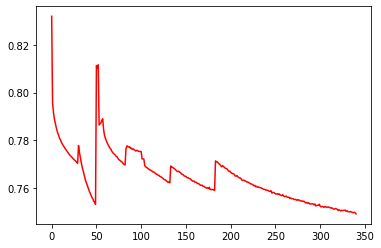

In [116]:
plt.plot(loss_list,color = 'r')
plt.savefig(model_path+"loss.png")

In [117]:
alphanet = alphanet.cpu()
pred_list = []
label_list = []
for _, (data, label) in enumerate(test_loader):
    data = Variable(data).float()
    pred = alphanet(data)
    pred_list.extend(pred.tolist())
    label_list.extend(label.tolist())

In [118]:
final = pd.DataFrame(pred_list)
final = pd.concat([target_list.reset_index(),final],axis=1)
final.rename(columns={0:Alpha_Name,'ticker': 'symbol'},inplace=True)
# final.set_index(["timestamp","symbol"],inplace=True)
final

,timestamp,symbol,target,AlphaNet_Original_Input_10d_return
0,2021-01-04 09:30:00,1,2.080068,-0.090760
1,2021-01-05 09:30:00,1,2.542624,0.030373
2,2021-01-06 09:30:00,1,2.731188,0.014308
3,2021-01-07 09:30:00,1,1.487784,-0.066718
4,2021-01-08 09:30:00,1,0.894896,-0.015251
...,...,...,...,...
402675,2021-05-25 09:30:00,688981,-0.262939,-0.044052
402676,2021-05-26 09:30:00,688981,-0.222002,0.034439
402677,2021-05-27 09:30:00,688981,-0.212631,0.003067
402678,2021-05-28 09:30:00,688981,-0.232948,-0.074640


In [119]:
final.to_parquet(output_path
                + test_timestamp[0].split("_")[0] + "_" + test_timestamp[-1].split("_")[-1])